### Helper functions

In [1]:
import pandas as pd
from IPython.display import display
import os
import json

os.chdir('..')

In [2]:
!pwd

/Users/alexc/Desktop/UofG/Lvl5-Project/test-suite-enhancement


In [3]:
from src.evaluation_entry import EvaluationEntry


In [4]:
def get_initial_eval_entry_csv(project_name):
    eval_entries = EvaluationEntry.load_all("initial", project_name)
    data = []

    for eval_entry in eval_entries:
        eval_entry_data = eval_entry.get_eval_entry_csv()
        data.append(eval_entry_data)
    
    init_dfs = pd.concat(data, ignore_index=True)
    # display(init_dfs)
    return init_dfs

In [5]:
def get_enhanced_eval_data(project, settings, optimised_eval=False):
    eval_entries = EvaluationEntry.load_all("enhanced", project)
    data = []
    for eval_entry in eval_entries:
        if "flag" in eval_entry.identifiers and eval_entry.identifiers["flag"] == "old_1":
            continue
        if settings.get('test_source') and eval_entry.get_test_source() != settings['test_source']:
            continue
        if settings.get('test_selection_mode') and eval_entry.identifiers['test_selection_mode'] != settings['test_selection_mode']:
            continue
        if settings.get('num_test_cases') and eval_entry.identifiers['num_test_cases'] != settings['num_test_cases']:
            continue
        if optimised_eval:
            data.append(eval_entry.get_optimised_eval_entry_csv())
        else:
            data.append(eval_entry.get_eval_entry_csv())
    
    enhanced_dfs = pd.concat(data, ignore_index=True)
    return enhanced_dfs

# Example usage
settings = {
    'test_source': "human_written",
    'test_selection_mode': None,
    'num_test_cases': None
}
enhanced_dfs = get_enhanced_eval_data("human_eval", settings)
display(enhanced_dfs)

,eval_id,test_source,num_test_cases,test_selection_mode,total_classes,total_tests,passed,passed_after_repair,syntax_errors,syntax_errors_after_repair,...,cognitive_complexity,cyclomatic_complexity,squale_index,code_smells,bugs,vulnerabilities,syntactically_correct,syntactically_correct_after_repair,compilable,compilable_after_repair
0,0/human_written/random_from_all/1,human_written,1,random_from_all,164,1312,0,1021,0,0,...,7,1023,461,45,34,0,164,164,164,164
1,1/human_written/random_from_all/3,human_written,3,random_from_all,164,1403,8,1139,0,0,...,3,1140,461,45,27,0,164,164,164,164
2,2/human_written/random_from_all/5,human_written,5,random_from_all,164,1499,8,1206,0,0,...,5,1208,632,63,31,0,164,164,164,164
3,3/human_written/random_from_class_under_test/1,human_written,1,random_from_class_under_test,164,1545,7,1173,0,0,...,1,1178,641,60,38,0,164,164,164,164
4,4/human_written/random_from_class_under_test/3,human_written,3,random_from_class_under_test,164,1588,0,1250,0,0,...,2,1252,944,91,31,0,164,164,164,164
5,5/human_written/random_from_class_under_test/5,human_written,5,random_from_class_under_test,164,1602,0,1243,0,0,...,4,1246,744,74,33,0,164,164,164,164
6,6/human_written/problem_similarity/1,human_written,1,problem_similarity,164,1274,0,977,1,0,...,0,977,533,56,33,0,163,164,164,164
7,7/human_written/problem_similarity/3,human_written,3,problem_similarity,164,1468,0,1164,0,0,...,3,1166,358,30,26,0,164,164,164,164
8,8/human_written/problem_similarity/5,human_written,5,problem_similarity,164,1521,6,1235,0,0,...,7,1235,392,33,28,0,164,164,164,164
9,9/human_written/class_similarity_no_definition/1,human_written,1,class_similarity_no_definition,164,1278,0,1004,0,0,...,0,1004,441,52,33,0,164,164,164,164


In [6]:
# Get initial eval entry data
init_dfs = get_initial_eval_entry_csv("human_eval")
display(init_dfs)

KeyError: 'execution_duration'

## RQ 1.1: Test correctness

### Figure code

In [7]:
def create_correctness_table(df):
    correctness_cols = [
        'total_tests',
        'total_classes',
        'syntactically_correct',
        'syntactically_correct_after_repair',
        'compilable',
        'compilable_after_repair',
        'passed',
        'passed_after_repair',
        # 'no_test_classes_after_repair'
    ]

    # Create correctness table
    melted = df.melt(
        id_vars=['test_source'],
        value_vars=correctness_cols,
        var_name='metric',
        value_name='value'
    )
    correctness_table = melted.pivot(index='metric', columns='test_source', values='value').fillna(0).astype(int)
    correctness_table = correctness_table.reindex(correctness_cols)
    # Sort the table by the order of correctness_cols
    

    # Create percentage table
    percentage_table = correctness_table.copy().astype(float)

    for col in percentage_table.columns:
        total_tests = percentage_table.loc['total_tests', col]
        total_classes = percentage_table.loc['total_classes', col]
        for idx in percentage_table.index:
            if idx != 'total_tests' and idx != 'total_classes':
                if idx in ['passed', 'passed_after_repair']:
                    total = total_tests
                else:
                    total = total_classes
                percentage_table.loc[idx, col] = (percentage_table.loc[idx, col] / total * 100) if total > 0 else 0.0
            else:
                percentage_table.loc[idx, col] = None  # No % for total_classes

    # Format values
    percentage_table = percentage_table.applymap(
        lambda x: f"{x:.2f}%" if pd.notna(x) else ""
    )
    correctness_table = correctness_table.astype(str)
    percentage_table.index = [f"{i} (%)" if i != 'total_tests' else '' for i in correctness_table.index]

    # Combine both tables
    combined_table = pd.concat([correctness_table, percentage_table])
    combined_table = combined_table[combined_table.index != '']

    # Display
    print(combined_table)

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def create_rule_repair_figure(df:pd.DataFrame):
    repair_cols = [col for col in df.columns if col.endswith('_repair_count') and col.startswith('rule_') and col != 'rule_1_repair_count']

    melted_df = df.melt(
        id_vars=['test_source'],
        value_vars=repair_cols,
        var_name='rule',
        value_name='repair_count'
    )
    melted_df['rule'] = melted_df['rule'].str.replace('_repair_count', '').str.replace('rule_', 'Rule ')

    plt.figure(figsize=(12, 6))
    sns.barplot(data=melted_df, x='rule', y='repair_count', hue='test_source')

    # plt.yscale('log') # Use log scale to better visualize the differences

    plt.title('Repair Count by Rule per Test Source (on log scale)')
    plt.xlabel('Repair Rule')
    plt.ylabel('Repair Count')
    plt.legend(title='Test Source', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

### Figures

In [17]:
settings = {
    'test_source': None,
    'test_selection_mode': "random_from_all",
    'num_test_cases': 5
}
print("ENHANCED DATA")
used_settings = { k:v for k,v in settings.items() if v is not None }
for setting in used_settings:
    print(f"{setting}: {used_settings[setting]}")
rq1_1_dfs = get_enhanced_eval_data("human_eval", settings)
create_correctness_table(rq1_1_dfs)

ENHANCED DATA
test_selection_mode: random_from_all
num_test_cases: 5
test_source                             chatgpt human_written  pynguin
total_tests                                1402          1499     1511
total_classes                               164           164      164
syntactically_correct                       164           164      163
syntactically_correct_after_repair          164           164      163
compilable                                  164           164      159
compilable_after_repair                     164           164      164
passed                                       16             8      168
passed_after_repair                        1096          1206     1114
total_classes (%)                                                     
syntactically_correct (%)               100.00%       100.00%   99.39%
syntactically_correct_after_repair (%)  100.00%       100.00%   99.39%
compilable (%)                          100.00%       100.00%   96.95%
compilab

/var/folders/z7/grqfp40j73xcvr_rkz8n20hm0000gn/T/ipykernel_51058/2442684477.py:43: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  percentage_table = percentage_table.applymap(


REPAIR COUNT


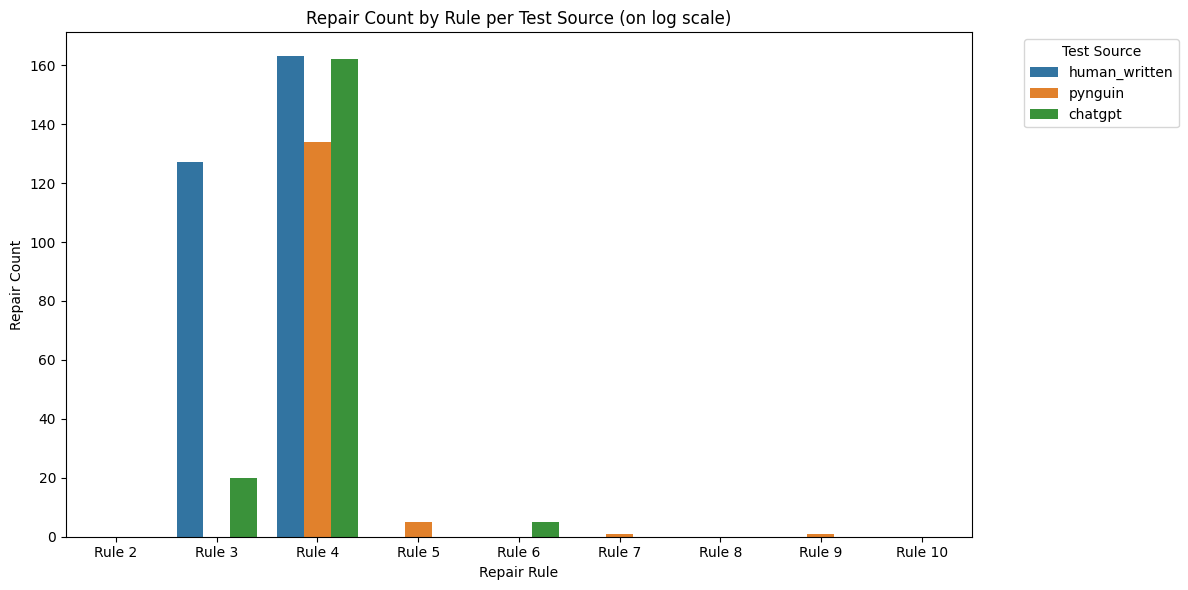

In [18]:
# Display the repair count figure
print("REPAIR COUNT")
create_rule_repair_figure(rq1_1_dfs)

# TODO: rerun the full "1/human_written/random_from_all/3" experiment

## RQ 1.2: Coverage metrics

### Figure code

In [23]:
# Coverage metrics

def create_coverage_table(df, settings=None):
    coverage_cols = [
        # "coverage",
        "branch_coverage",
        "line_coverage",
        # "lines_to_cover",
        # "uncovered_lines"
    ]
    
    # Make the value which is None as id_var
    if settings is not None:
        id_var = next((k for k, v in settings.items() if v is None), None)
    else:
        id_var = 'test_source'
        settings = 'initial'
    
    # Create correctness table
    melted = df.melt(
        id_vars=[id_var],
        value_vars=coverage_cols,
        var_name='metric',
        value_name='value'
    )
    coverage_table = melted.pivot(index='metric', columns=id_var, values='value').fillna(0)
    coverage_table = coverage_table.reindex(coverage_cols)
    # Sort the table by the order of coverage_cols

    # Format values
    coverage_table = coverage_table.astype(str) + "%"

    # Display
    print(f"INFO: {settings}")
    print(coverage_table)

### Figures

In [26]:
settings = {
    'test_source': None,
    'test_selection_mode': "random_from_all",
    'num_test_cases': 3
}
rq1_2_dfs = get_enhanced_eval_data("human_eval", settings)
create_coverage_table(rq1_2_dfs)

INFO: initial
test_source     chatgpt human_written pynguin
metric                                       
branch_coverage   85.7%         94.0%   91.2%
line_coverage     97.8%         98.8%   98.8%


## RQ 1.3: Code quality

### Figure code

In [33]:
# Code quality metrics

def create_code_quality_table(df, settings=None):
    code_quality_cols = [
        "cyclomatic_complexity",
        "cognitive_complexity",
        "squale_index",
        "code_smells",
        # "bugs",
        # "vulnerabilities"
        # "lines",
        "non_comment_lines",
        # "comment_lines",
    ]
    
    # Make the value which is None as id_var
    if settings is not None:
        id_var = next((k for k, v in settings.items() if v is None), None)
    else:
        id_var = 'test_source'
        settings = 'initial'
    
    # Create correctness table
    melted = df.melt(
        id_vars=[id_var],
        value_vars=code_quality_cols,
        var_name='metric',
        value_name='value'
    )
    code_quality_table = melted.pivot(index='metric', columns=id_var, values='value').fillna(0)
    code_quality_table = code_quality_table.reindex(code_quality_cols)
    # Sort the table by the order of coverage_cols

    # Format values
    code_quality_table = code_quality_table.astype(str)

    # Display
    print(f"INFO: {settings}")
    print(code_quality_table)

### Figures

In [34]:
settings = {
    'test_source': None,
    'test_selection_mode': "random_from_all",
    'num_test_cases': 3
}
rq1_3_dfs = get_enhanced_eval_data("human_eval", settings)
create_code_quality_table(rq1_3_dfs, settings)

INFO: {'test_source': None, 'test_selection_mode': 'random_from_all', 'num_test_cases': 3}
test_source           chatgpt human_written pynguin
metric                                             
cyclomatic_complexity    1090          1140    1053
cognitive_complexity        0             3       1
squale_index              250           461     365
code_smells                29            45      47
non_comment_lines        3097          3066    3402


## RQ 1.4: Test suite optimisation statistics

### Figure code

In [ ]:
# Create a table showing the total test numbers

def create_optimisation_test_count_table(df, settings=None, show_percentages=False):
    optimisation_test_count_cols = [
        "total_tests",
        "total_kept_tests",
        "total_removed_tests",
        "total_skipped_tests",
        # "total_faulty_tests"
    ]

    display_names = {
        "total_tests": "Total Tests",
        "total_kept_tests": "Kept Tests",
        "total_removed_tests": "Removed Tests",
        "total_skipped_tests": "Skipped Tests",
        # "total_faulty_tests": "Faulty Tests"
    }
    
    if settings is not None:
        id_var = next((k for k, v in settings.items() if v is None), None)
    else:
        id_var = 'test_source'
    
    # Create correctness table
    melted = df.melt(
        id_vars=[id_var],
        value_vars=optimisation_test_count_cols,
        var_name='metric',
        value_name='value'
    )
    if show_percentages:
        melted['value'] = melted['value'].astype(float)

    optimisation_test_count_table = melted.pivot(index='metric', columns=id_var, values='value').fillna(0)
    optimisation_test_count_table = optimisation_test_count_table.reindex(optimisation_test_count_cols) # Sort the table by the order of optimisation_test_count_cols
    
    if show_percentages:
        optimisation_test_count_table = optimisation_test_count_table.astype(float)
        # Calculate percentages for all metrics except total_tests
        total_tests = optimisation_test_count_table.loc["total_tests"]
        for metric in optimisation_test_count_cols[1:]:  # Skip total_tests
            optimisation_test_count_table.loc[metric] = (optimisation_test_count_table.loc[metric] / total_tests) * 100
        
        optimisation_test_count_table = optimisation_test_count_table.round(2)
        optimisation_test_count_table = optimisation_test_count_table.astype(str) + "%"
        
        optimisation_test_count_table = optimisation_test_count_table.drop("total_tests")
    else:
        optimisation_test_count_table = optimisation_test_count_table.astype(str)

    optimisation_test_count_table = optimisation_test_count_table.rename(index=display_names)

    # Display
    print(f"INFO: {settings}")
    print(optimisation_test_count_table)

### Figures

In [ ]:
# TODO: Make the test_source None!!
settings = {
    'test_source': "human_written",
    'test_selection_mode': "random_from_all",
    'num_test_cases': None
}
optimised_dfs = get_enhanced_eval_data("human_eval", settings, optimised_eval=True)
display(optimised_dfs)

,eval_id,test_source,num_test_cases,test_selection_mode,total_classes,total_tests,total_kept_tests,total_removed_tests,total_skipped_tests,total_faulty_tests,...,execution_time,lines,non_comment_lines,comment_lines,cognitive_complexity,cyclomatic_complexity,squale_index,code_smells,bugs,vulnerabilities
0,0/human_written/random_from_all/1,human_written,1,random_from_all,164,1183,15,124,1044,0,...,5.65,8435,3973,1898,605,1747,930,120,14,0
1,1/human_written/random_from_all/3,human_written,3,random_from_all,164,1167,14,64,1089,0,...,5.42,8448,3984,1903,605,1748,930,120,14,0
2,2/human_written/random_from_all/5,human_written,5,random_from_all,164,1235,16,66,1153,0,...,7.70,8452,3987,1899,605,1750,930,120,14,0


In [ ]:
data = optimised_dfs.copy()
# display(data)
create_optimisation_test_count_table(data, settings=settings)

INFO: {'test_source': 'human_written', 'test_selection_mode': 'random_from_all', 'num_test_cases': None}
num_test_cases     1     3     5
metric                          
Total Tests     1183  1167  1235
Kept Tests        15    14    16
Removed Tests    124    64    66
Skipped Tests   1044  1089  1153


In [ ]:
data = optimised_dfs.copy()
# display(data)
create_optimisation_test_count_table(data, settings=settings, show_percentages=True)

INFO: {'test_source': 'human_written', 'test_selection_mode': 'random_from_all', 'num_test_cases': None}
num_test_cases       1       3       5
metric                                
Kept Tests       1.27%    1.2%    1.3%
Removed Tests   10.48%   5.48%   5.34%
Skipped Tests   88.25%  93.32%  93.36%


In [ ]:
# Compare the initial and optimised coverage metrics